Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 178, 50)           27035350  
                                                                 
 conv1d_4 (Conv1D)           (None, 176, 32)           4832      
                                                                 
 global_max_pooling1d_4 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                      

<ipython-input-10-b224bc3d5457>:75: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, times, 'bo', label='Epochs vs Time Taken', color='blue')


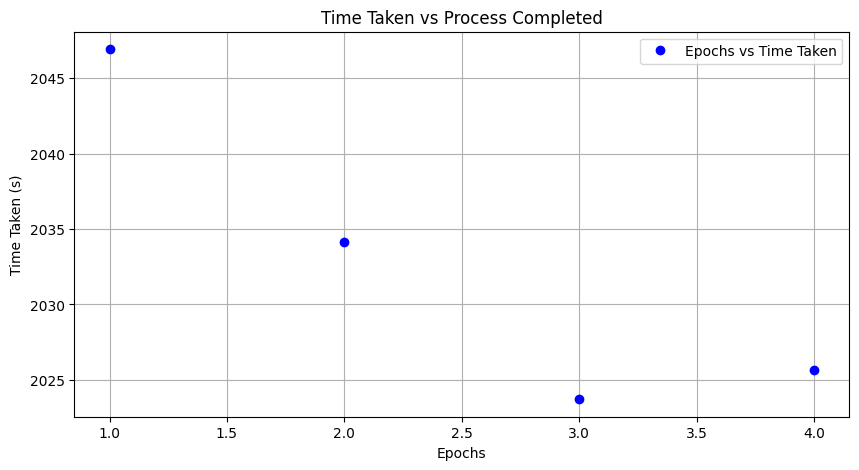

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
import matplotlib.pyplot as plt
import time

# Load the dataset (assuming it's in a CSV file with 'url' and 'label' columns)
data = pd.read_csv("/content/balanced_urls.csv")

# Tokenization and vectorization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['url'])
sequences = tokenizer.texts_to_sequences(data['url'])
word_index = tokenizer.word_index
max_sequence_length = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=max_sequence_length)
y = data['label']  # Assuming 'label' column contains categorical labels

# Convert labels to numerical values using label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert numerical labels to float32
y = y_encoded.astype(np.float32)

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # Increase test size to 30%
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_start_time)

# Model architecture
model = Sequential()
model.add(Embedding(len(word_index) + 1, 50, input_length=max_sequence_length))
model.add(Conv1D(32, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))  # Dropout layer added
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Training callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
time_history = TimeHistory()

# Train the model
start_time = time.time()
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr, time_history])
end_time = time.time()
print("Training Time:", end_time - start_time, "seconds")

# Plot time taken vs process completed
plt.figure(figsize=(10, 5))

epochs = range(1, len(history.history['accuracy']) + 1)
times = time_history.times

plt.plot(epochs, times, 'bo', label='Epochs vs Time Taken', color='blue')
plt.title('Time Taken vs Process Completed')
plt.xlabel('Epochs')
plt.ylabel('Time Taken (s)')
plt.legend()
plt.grid(True)

plt.show()
